In [3]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GlobalMaxPool1D, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
# 加载数据
data = np.load('data/data.npz', allow_pickle=True)
x = data['x']  # 词索引序列
y = data['y']  # 情感标签

# 数据预处理
# 确定词汇表大小（取最大索引值+1）
vocab_size = max(max(seq) for seq in x) + 1

# 确定最大序列长度（取所有序列长度的第95百分位数）
seq_lengths = [len(seq) for seq in x]
max_len = int(np.percentile(seq_lengths, 95))

# 序列填充（前填充）
x_padded = pad_sequences(x, maxlen=max_len, padding='pre', truncating='pre')

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(
    x_padded, y, test_size=0.2, random_state=42, stratify=y
)

In [5]:
# 构建模型
def create_model(vocab_size, embedding_dim=128, max_len=100):
    model = Sequential()
    
    # 嵌入层 - 将词索引转换为密集向量
    model.add(Embedding(
        input_dim=vocab_size, 
        output_dim=embedding_dim, 
        input_length=max_len,
        mask_zero=True  # 忽略填充值
    ))
    
    # 双向LSTM层 - 捕捉序列上下文信息
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    
    # 全局池化层 - 提取序列重要特征
    model.add(GlobalMaxPool1D())
    
    # 全连接层
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    
    # 输出层 - 二分类
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# 创建模型
model = create_model(vocab_size, embedding_dim=128, max_len=max_len)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 45, 128)           9605248   
                                                                 
 bidirectional_1 (Bidirecti  (None, 45, 128)           98816     
 onal)                                                           
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [6]:
# 训练配置
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True
)

# 训练模型
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# 评估模型
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n测试集准确率: {test_acc:.4f}")

Epoch 1/20
324/324 [==============================] - 39s 109ms/step - loss: 0.3805 - accuracy: 0.8412 - val_loss: 0.2961 - val_accuracy: 0.8812
Epoch 2/20
324/324 [==============================] - 33s 103ms/step - loss: 0.1444 - accuracy: 0.9509 - val_loss: 0.3217 - val_accuracy: 0.8747
Epoch 3/20
324/324 [==============================] - 33s 102ms/step - loss: 0.0605 - accuracy: 0.9820 - val_loss: 0.4902 - val_accuracy: 0.8625
Epoch 4/20
324/324 [==============================] - 33s 102ms/step - loss: 0.0328 - accuracy: 0.9902 - val_loss: 0.5530 - val_accuracy: 0.8555

测试集准确率: 0.8820


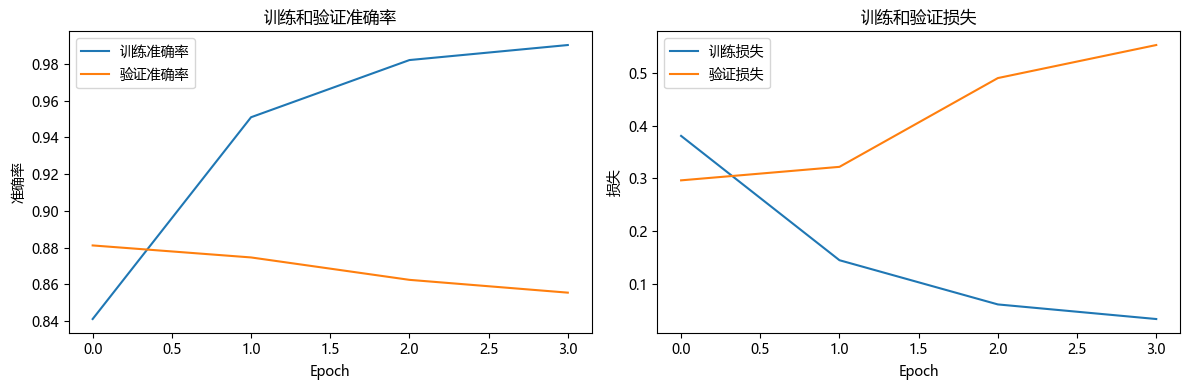

模型已保存为 'sentiment_analysis_model.h5'


In [ ]:
plt.rc('font', family='Microsoft YaHei')

# 可视化训练过程
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='训练准确率')
    plt.plot(history.history['val_accuracy'], label='验证准确率')
    plt.title('训练和验证准确率')
    plt.xlabel('Epoch')
    plt.ylabel('准确率')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='训练损失')
    plt.plot(history.history['val_loss'], label='验证损失')
    plt.title('训练和验证损失')
    plt.xlabel('Epoch')
    plt.ylabel('损失')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)

# 保存模型
model.save('sentiment_analysis_model.h5')
print("模型已保存为 'sentiment_analysis_model.h5'")